# Variazione prezzo NFT

#### Importazione librerie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import os

### nft_trades dataset import

In [2]:
# Definire i tipi di dati per ogni colonna
dtype = {
    'contract_address': str,
    'transaction_hash': str,
    'num_items': int,
    'seller': str,
    'buyer': str,
    'token_id': str,
    'avg_price': float,
    'currency': str,
    'currency_address': str,
    'usd_amount': float,
    'platform': str
}

# Leggere il file CSV
nft_trades_ds = pd.read_csv("../datasets/nfts/nft_trades.csv", chunksize=100000, dtype=dtype, lineterminator='\n', low_memory=False, parse_dates=['date'])
nft_trades_df = pd.concat(nft_trades_ds)

nft_trades_df.info()
nft_trades_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507678 entries, 0 to 507677
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              507678 non-null  datetime64[ns]
 1   transaction_hash  507678 non-null  object        
 2   num_items         507678 non-null  int64         
 3   seller            507678 non-null  object        
 4   buyer             507678 non-null  object        
 5   token_id          507678 non-null  object        
 6   avg_price         507678 non-null  float64       
 7   currency          507678 non-null  object        
 8   usd_amount        507678 non-null  float64       
 9   platform          507678 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 38.7+ MB


(507678, 10)

In [3]:
# we assiacure that there are no cells with null values in the date and text columns
nft_trades_df.dropna(axis=0 ,subset=['date', 'token_id', 'avg_price', 'transaction_hash', 'seller', 'buyer', 'currency', 'platform'],inplace = True)
nft_trades_df.reset_index(drop= True,inplace=True)
nft_trades_df.shape

(507678, 10)

In [4]:
# Check for null values
null_values = nft_trades_df.isnull().sum()
print("Null values in each column:\n", null_values)

# Check for duplicates
duplicate_rows = nft_trades_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

Null values in each column:
 date                0
transaction_hash    0
num_items           0
seller              0
buyer               0
token_id            0
avg_price           0
currency            0
usd_amount          0
platform            0
dtype: int64
Number of duplicate rows: 19018


In [5]:
# Data cleaning 
nft_trades_df.drop_duplicates(inplace = True)
nft_trades_df.reset_index(drop=True,inplace=True)
nft_trades_df.shape

(488660, 10)

In [6]:
# Setting dataset column types
#nft_trades_df = nft_trades_df.convert_dtypes()
#nft_trades_df.dtypes

In [7]:
# Convertire la colonna 'date' in formato datetime
nft_trades_df['date'] = pd.to_datetime(nft_trades_df['date'])

# Selezionare le righe con data successiva al 15 novembre 2020
new_nft_trades = nft_trades_df[nft_trades_df['date'] > '2020-11-15']

# Ordinare il DataFrame per token_id e data
filtrate_nft_trades_sorted = new_nft_trades.sort_values(by=['token_id', 'date'])

### Calcolo e identificazione delle variazioni di prezzo

In [8]:
#print(filtrate_nft_trades_sorted.groupby('token_id').size())

In [9]:
# Calcolare le variazioni di prezzo per ogni token_id
filtrate_nft_trades_sorted['price_change'] = filtrate_nft_trades_sorted.groupby('token_id')['avg_price'].diff()

# Identificare le variazioni positive e negative consecutive
filtrate_nft_trades_sorted['price_trend'] = (
    filtrate_nft_trades_sorted['price_change']
    .apply(lambda x: 'positivo' if x > 0 else ('negativo' if x < 0 else 'nessuna variazione'))
)

# Raggruppare le variazioni consecutive
filtrate_nft_trades_sorted['trend_change'] = (
    (filtrate_nft_trades_sorted['price_trend'] != filtrate_nft_trades_sorted['price_trend'].shift())
    .astype(int)
    .cumsum()
)

### Aggregazione e filtraggio delle variazioni di prezzo

In [10]:
# Raggruppare per token_id e trend_change per trovare le date di inizio e fine delle variazioni
grouped = filtrate_nft_trades_sorted.groupby(['token_id', 'trend_change', 'price_trend']).agg(
    data_inizio=('date', 'first'),
    data_fine=('date', 'last'),
    prezzo_inizio=('avg_price', 'first'),
    prezzo_fine=('avg_price', 'last')
).reset_index()

# Filtrare casi con prezzo_inizio o prezzo_fine uguali a 0
grouped = grouped[(grouped['prezzo_inizio'] != 0) & (grouped['prezzo_fine'] != 0)]

# Calcolare la percentuale di variazione del prezzo, ignorando i casi con nessuna variazione di prezzo
grouped['percentuale_variazione'] = grouped.apply(
    lambda row: (row['prezzo_fine'] - row['prezzo_inizio']) / row['prezzo_inizio'] * 100
    if row['prezzo_inizio'] != row['prezzo_fine'] else 0, axis=1
)

# Filtrare solo le variazioni di prezzo, escludendo "nessuna variazione"
price_changes = grouped[grouped['price_trend'] != 'nessuna variazione']


### Calcolo dei prezzi medi e filtraggio delle variazioni significative

In [11]:
# Calcolare il prezzo medio per ogni token_id
average_prices = filtrate_nft_trades_sorted.groupby('token_id')['avg_price'].mean().reset_index()
average_prices.rename(columns={'avg_price': 'avg_price_avg'}, inplace=True)

# Unire il prezzo medio con il DataFrame delle variazioni di prezzo
price_changes_with_avg = price_changes.merge(average_prices, on='token_id', how='left')

# Selezionare le colonne desiderate
result = price_changes_with_avg[['data_inizio', 'data_fine', 'token_id', 'price_trend', 'trend_change', 'prezzo_inizio', 'prezzo_fine', 'avg_price_avg', 'percentuale_variazione']]

# Definire la soglia per la percentuale di variazione
threshold = 90  # Ad esempio, il 150%

# Filtrare i risultati che superano la soglia in positivo o negativo
result_filtered = result[(result['percentuale_variazione'] > threshold) | (result['percentuale_variazione'] < -threshold)]


### Selezione dei top token con variazioni positive e negative

In [12]:
# Selezionare i top 10 token con variazioni positive e negative
top_nft_positivi = result_filtered.nlargest(10, 'percentuale_variazione')
top_nft_negativi = result_filtered.nsmallest(10, 'percentuale_variazione')

# Unire i due DataFrame
top_tokens = pd.concat([top_nft_positivi, top_nft_negativi])


### Visualizzazione dell'andamento delle variazioni di prezzo (positivi e negativi)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


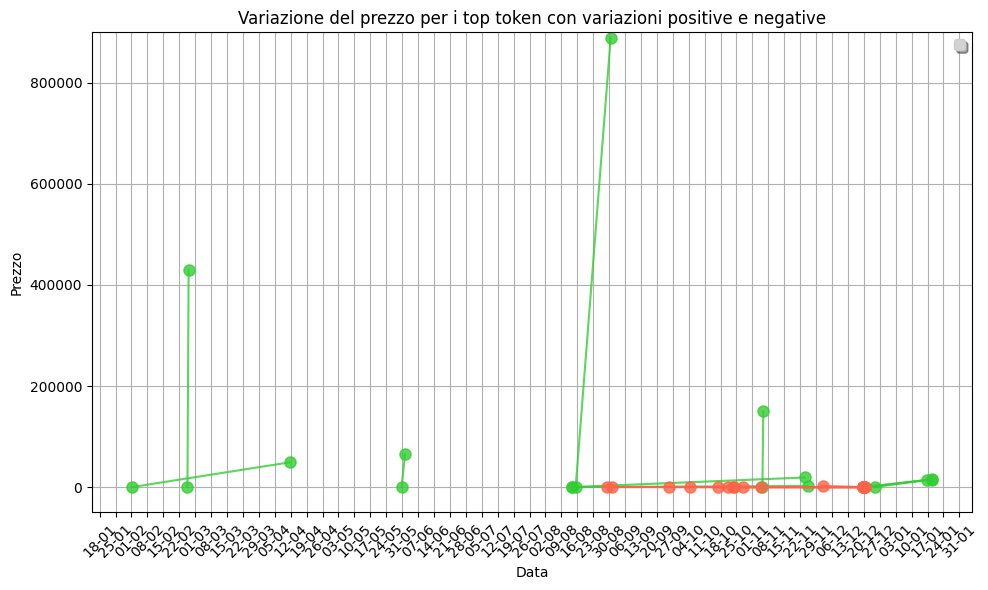

In [13]:
# Impostare la dimensione della figura
plt.figure(figsize=(10,6))

# Impostare i limiti dell'asse y
plt.ylim(-50000, 900000)

# Convertire le date nel formato matplotlib
top_tokens['data_inizio'] = pd.to_datetime(top_tokens['data_inizio'])
top_tokens['data_fine'] = pd.to_datetime(top_tokens['data_fine'])

# Iterare sui token e tracciare le variazioni di prezzo
for _, row in top_tokens.iterrows():
    color = 'limegreen' if row['percentuale_variazione'] > 0 else 'tomato'  # Cambiare il colore dei marker
    plt.plot([row['data_inizio'], row['data_fine']], [row['prezzo_inizio'], row['prezzo_fine']], color=color, linestyle='-', marker='o', markersize=8, alpha=0.8)  # Cambiare lo stile delle linee e dei marker

# Formattare l'asse x per mostrare solo i giorni
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Impostare un intervallo di 7 giorni

plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.title('Variazione del prezzo per i top token con variazioni positive e negative')
plt.grid(True)
legend = plt.legend(loc='best', shadow=True, fancybox=True)
legend.get_frame().set_facecolor('lightgrey')
plt.xticks(rotation=45) 
plt.tight_layout()  
plt.show()

### Visualizzazione dell'andamento delle variazioni di prezzo (positivi)

/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1082/1833179866.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picchi_positivi['data_inizio'] = pd.to_datetime(picchi_positivi['data_inizio'])
/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1082/1833179866.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picchi_positivi['data_fine'] = pd.to_datetime(picchi_positivi['data_fine'])


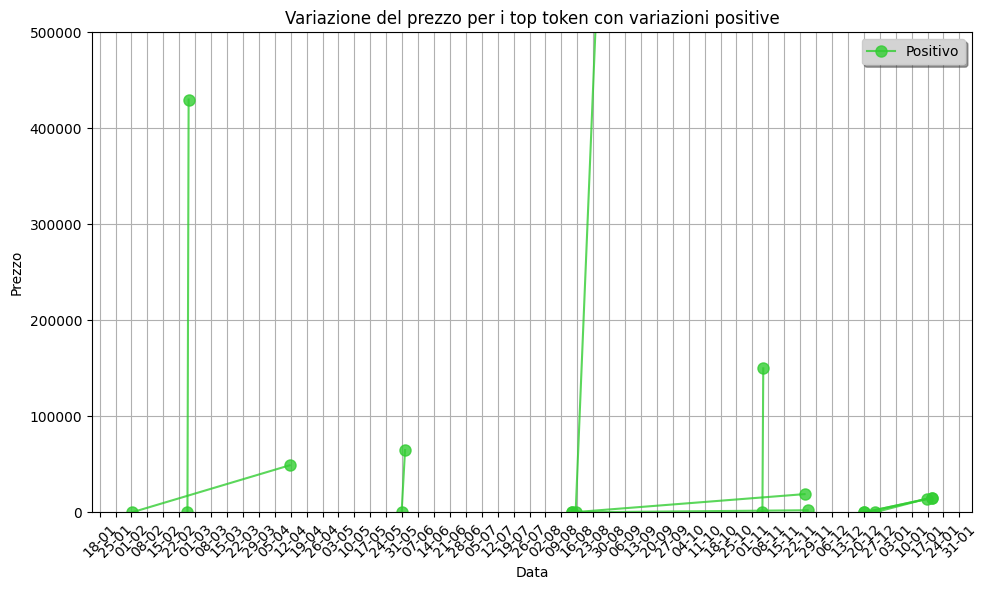

In [14]:
# Selezionare solo i picchi positivi
picchi_positivi = top_tokens[top_tokens['percentuale_variazione'] > 0]

# Impostare la dimensione della figura
plt.figure(figsize=(10, 6))

# Impostare i limiti dell'asse y
plt.ylim(0, 500000)

# Convertire le date nel formato matplotlib
picchi_positivi['data_inizio'] = pd.to_datetime(picchi_positivi['data_inizio'])
picchi_positivi['data_fine'] = pd.to_datetime(picchi_positivi['data_fine'])

# Iterare sui picchi positivi e tracciare le variazioni di prezzo
for _, row in picchi_positivi.iterrows():
    plt.plot([row['data_inizio'], row['data_fine']], [row['prezzo_inizio'], row['prezzo_fine']], color='limegreen', linestyle='-', marker='o', markersize=8, alpha=0.8)  # Cambiare lo stile delle linee e dei marker

# Formattare l'asse x per mostrare solo i giorni
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7)) 

plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.title('Variazione del prezzo per i top token con variazioni positive')
plt.grid(True)
legend = plt.legend(['Positivo'], loc='best', shadow=True, fancybox=True)
legend.get_frame().set_facecolor('lightgrey') 
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

### Visualizzazione dell'andamento delle variazioni di prezzo (negativi)

/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1082/3587847039.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picchi_negativi['data_inizio'] = pd.to_datetime(picchi_negativi['data_inizio'])
/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1082/3587847039.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picchi_negativi['data_fine'] = pd.to_datetime(picchi_negativi['data_fine'])


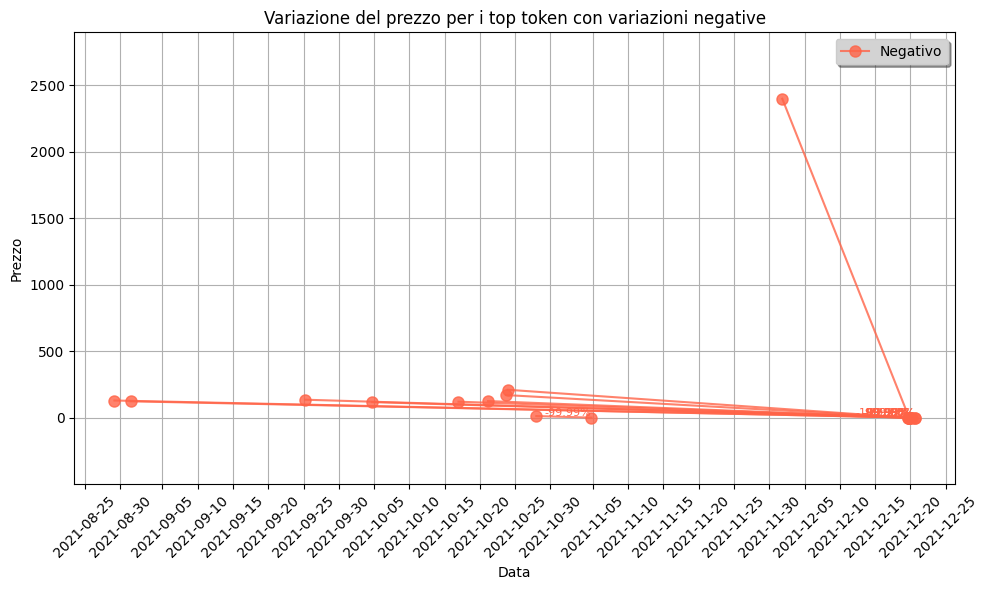

In [15]:
# Selezionare solo i picchi negativi
picchi_negativi = top_tokens[top_tokens['percentuale_variazione'] < 0]

# Impostare la dimensione della figura
plt.figure(figsize=(10,6))

# Impostare un intervallo più stretto per l'asse y
y_min = picchi_negativi['prezzo_fine'].min() - 500
y_max = picchi_negativi['prezzo_inizio'].max() + 500
plt.ylim(y_min, y_max)

# Convertire le date nel formato matplotlib
picchi_negativi['data_inizio'] = pd.to_datetime(picchi_negativi['data_inizio'])
picchi_negativi['data_fine'] = pd.to_datetime(picchi_negativi['data_fine'])

# Iterare sui picchi negativi e tracciare le variazioni di prezzo
for _, row in picchi_negativi.iterrows():
    plt.plot([row['data_inizio'], row['data_fine']], [row['prezzo_inizio'], row['prezzo_fine']], color='tomato', linestyle='-', marker='o', markersize=8, alpha=0.8)
    
    # Aggiungere l'etichetta della percentuale di variazione vicino al punto finale delle variazioni di prezzo
    plt.text(row['data_fine'], row['prezzo_fine'], f"{row['percentuale_variazione']:.2f}%", color='tomato', fontsize=8, ha='right', va='bottom')

# Formattare l'asse x per mostrare solo alcuni giorni a intervalli di 5 giorni
days_locator = mdates.DayLocator(bymonthday=[5, 10, 15, 20, 25, 30])
plt.gca().xaxis.set_major_locator(days_locator)

plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.title('Variazione del prezzo per i top token con variazioni negative')
plt.grid(True)
legend = plt.legend(['Negativo'], loc='best', shadow=True, fancybox=True)
legend.get_frame().set_facecolor('lightgrey')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualizzazione dell'andamento delle variazioni di prezzo (negativi) con focus sul picco che vogliamo analizzare

/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1082/598613833.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picchi_negativi['data_inizio'] = pd.to_datetime(picchi_negativi['data_inizio'])
/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1082/598613833.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picchi_negativi['data_fine'] = pd.to_datetime(picchi_negativi['data_fine'])


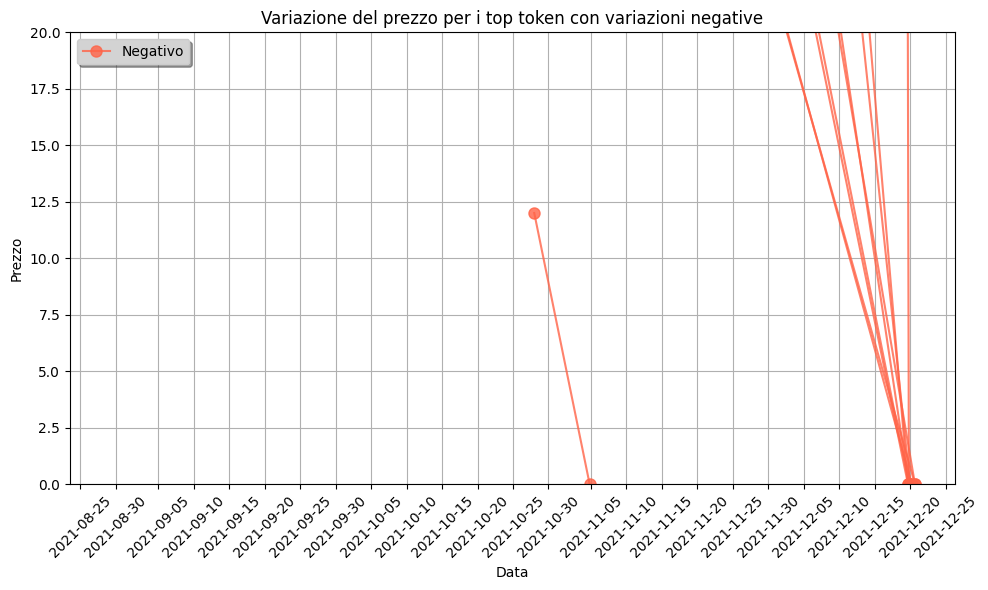

In [16]:
# Selezionare solo i picchi negativi
picchi_negativi = top_tokens[top_tokens['percentuale_variazione'] < 0]

# Impostare la dimensione della figura
plt.figure(figsize=(10, 6))

# Impostare un intervallo più stretto per l'asse y
y_min = 0
#y_min = picchi_negativi['prezzo_fine'].min() - 500
y_max = 20
#y_max = picchi_negativi['prezzo_inizio'].max() + 500
plt.ylim(y_min, y_max)

# Convertire le date nel formato matplotlib
picchi_negativi['data_inizio'] = pd.to_datetime(picchi_negativi['data_inizio'])
picchi_negativi['data_fine'] = pd.to_datetime(picchi_negativi['data_fine'])

# Iterare sui picchi negativi e tracciare le variazioni di prezzo
for _, row in picchi_negativi.iterrows():
    plt.plot([row['data_inizio'], row['data_fine']], [row['prezzo_inizio'], row['prezzo_fine']], color='tomato', linestyle='-', marker='o', markersize=8, alpha=0.8)  # Cambiare lo stile delle linee e dei marker

# Formattare l'asse x per mostrare solo alcuni giorni a intervalli di 5 giorni
days_locator = mdates.DayLocator(bymonthday=[5, 10, 15, 20, 25, 30])
plt.gca().xaxis.set_major_locator(days_locator)

plt.xlabel('Data')
plt.ylabel('Prezzo')
plt.title('Variazione del prezzo per i top token con variazioni negative')
plt.grid(True)
legend = plt.legend(['Negativo'], loc='best', shadow=True, fancybox=True)
legend.get_frame().set_facecolor('lightgrey') 
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

### Analisi delle variazioni per unit time

In [17]:
# Calcoliamo la durata in secondi per le variazioni positive
top_nft_positivi['durata'] = (top_nft_positivi['data_fine'] - top_nft_positivi['data_inizio']).dt.total_seconds()

# Calcoliamo la variazione percentuale per unità di tempo
top_nft_positivi['variazione_per_sec'] = top_nft_positivi['percentuale_variazione'] / top_nft_positivi['durata']

# Ordiniamo i risultati per variazione_per_sec in ordine decrescente
top_nft_positivi = top_nft_positivi.sort_values(by='variazione_per_sec', ascending=False)
print (top_nft_positivi)
print ('---------')

# Visualizziamo i risultati
top_nft_pos = top_nft_positivi.head(5)
print(top_nft_pos)

               data_inizio           data_fine token_id price_trend  \
83436  2021-08-15 07:05:16 2021-08-30 16:33:32     6563    positivo   
52069  2021-11-05 09:46:35 2021-11-05 18:42:28     4037    positivo   
7936   2021-02-25 14:23:29 2021-02-26 02:48:36    12247    positivo   
111335 2021-05-30 18:06:57 2021-06-01 06:39:14     8898    positivo   
60451  2021-12-20 02:29:35 2022-01-18 23:35:20     4704    positivo   
94742  2021-12-24 19:11:50 2022-01-16 23:52:30     7451    positivo   
52722  2021-12-20 06:56:51 2022-01-18 23:39:20     4092    positivo   
98745  2021-08-13 16:31:59 2021-11-23 22:33:31     7787    positivo   
83344  2021-08-13 16:13:35 2021-11-25 07:08:39     6555    positivo   
15770  2021-02-01 04:19:35 2021-04-11 12:31:33    14428    positivo   

        trend_change  prezzo_inizio  prezzo_fine  avg_price_avg  \
83436         136359          0.130     888888.0   42335.513029   
52069          91506          1.400     150000.0    6526.103130   
7936           16

In [18]:
# Calcoliamo la durata in secondi per le variazioni negative
top_nft_negativi['durata'] = (top_nft_negativi['data_fine'] - top_nft_negativi['data_inizio']).dt.total_seconds()

# Calcoliamo la variazione percentuale per unità di tempo
top_nft_negativi['variazione_per_sec'] = top_nft_negativi['percentuale_variazione'] / top_nft_negativi['durata']

# Ordiniamo i risultati per variazione_per_sec in ordine crescente
top_nft_negativi = top_nft_negativi.sort_values(by='variazione_per_sec', ascending=True)
print (top_nft_negativi)
print ('---------')
# Visualizziamo i risultati
top_nft_neg = top_nft_negativi.head(1)
print(top_nft_neg)

               data_inizio           data_fine token_id price_trend  \
112819 2021-10-27 23:46:06 2021-11-04 19:14:53     9032    negativo   
41756  2021-12-01 20:23:47 2021-12-19 19:48:02     3123    negativo   
103492 2021-10-23 22:12:53 2021-12-19 16:06:38      820    negativo   
62916  2021-10-23 16:37:18 2021-12-19 23:42:32     4901    negativo   
35379  2021-10-21 03:22:09 2021-12-19 18:51:27     2569    negativo   
119418 2021-10-16 23:04:11 2021-12-20 15:58:38     9610    negativo   
8858   2021-10-04 17:34:38 2021-12-19 16:23:24     1254    negativo   
39984  2021-09-25 05:25:42 2021-12-19 19:31:04     2976    negativo   
117745 2021-08-31 11:47:42 2021-12-20 15:58:28     9456    negativo   
95900  2021-08-29 04:46:46 2021-12-20 05:25:01     7545    negativo   

        trend_change  prezzo_inizio  prezzo_fine  avg_price_avg  \
112819        176183          12.00        0.001       3.338750   
41756          76606        2400.00        0.020     331.495284   
103492        163

### Confronto variazione del prezzo per secondo per i picchi positivi

/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1082/1102913338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picchi_positivi['durata'] = (picchi_positivi['data_fine'] - picchi_positivi['data_inizio']).dt.total_seconds()
/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1082/1102913338.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picchi_positivi['variazione_per_sec'] = picchi_positivi['percentuale_variazione'] / picchi_positivi['durata']


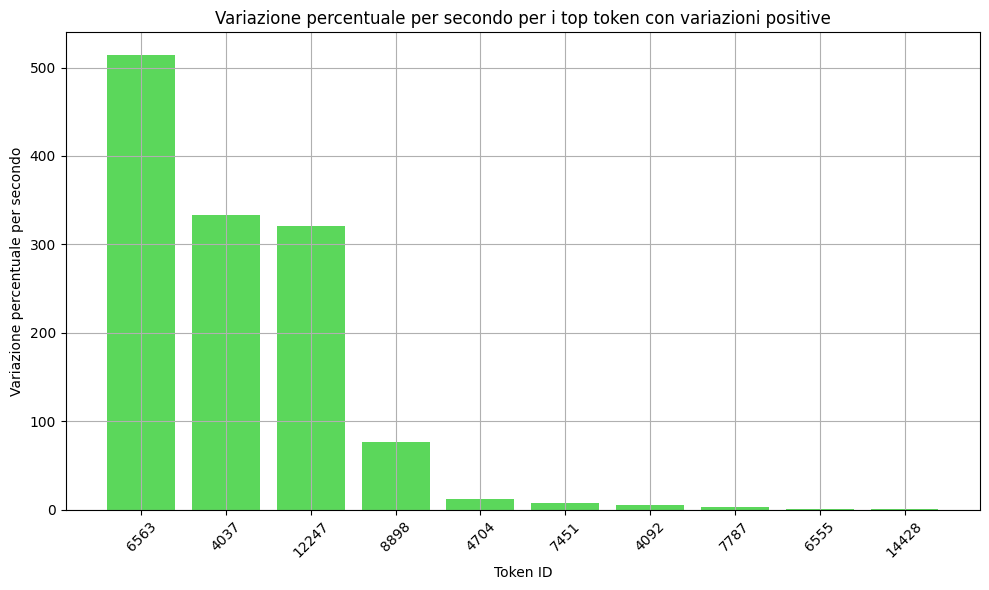

In [19]:
# Calcoliamo la variazione percentuale per unità di tempo (secondo) per i picchi positivi
picchi_positivi['durata'] = (picchi_positivi['data_fine'] - picchi_positivi['data_inizio']).dt.total_seconds()
picchi_positivi['variazione_per_sec'] = picchi_positivi['percentuale_variazione'] / picchi_positivi['durata']

# Ordiniamo i risultati per variazione_per_sec in ordine decrescente
picchi_positivi_sorted = picchi_positivi.sort_values(by='variazione_per_sec', ascending=False)

# Impostiamo la dimensione della figura
plt.figure(figsize=(10,6))

# Grafico a barre delle variazioni percentuali per secondo
plt.bar(picchi_positivi_sorted['token_id'], picchi_positivi_sorted['variazione_per_sec'], color='limegreen', alpha=0.8)

# Aggiungiamo etichette e titolo
plt.xlabel('Token ID')
plt.ylabel('Variazione percentuale per secondo')
plt.title('Variazione percentuale per secondo per i top token con variazioni positive')
plt.xticks(rotation=45)
plt.grid(True)

# Mostrare il grafico
plt.tight_layout()
plt.show()

### Confronto variazione del prezzo per secondo per i picchi negativi

/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1082/3469311775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picchi_negativi['durata'] = (picchi_negativi['data_fine'] - picchi_negativi['data_inizio']).dt.total_seconds()
/var/folders/ht/ykt5nd_d1w55_nvpcjzwqvmw0000gn/T/ipykernel_1082/3469311775.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  picchi_negativi['variazione_per_sec'] = picchi_negativi['percentuale_variazione'] / picchi_negativi['durata']


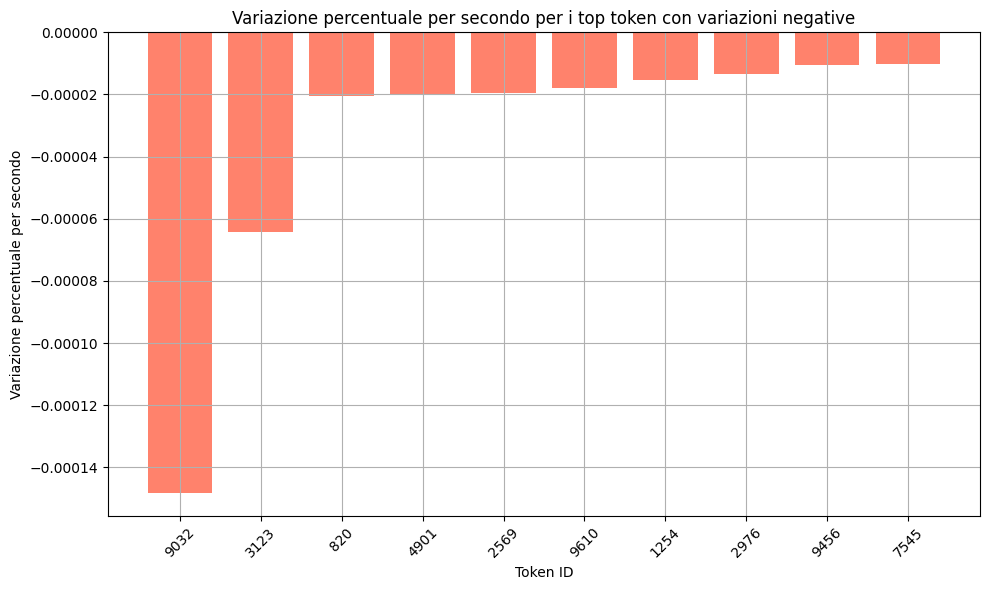

In [20]:
# Calcoliamo la variazione percentuale per unità di tempo (secondo) per i picchi negativi
picchi_negativi['durata'] = (picchi_negativi['data_fine'] - picchi_negativi['data_inizio']).dt.total_seconds()
picchi_negativi['variazione_per_sec'] = picchi_negativi['percentuale_variazione'] / picchi_negativi['durata']

# Ordiniamo i risultati per variazione_per_sec in ordine crescente
picchi_negativi_sorted = picchi_negativi.sort_values(by='variazione_per_sec', ascending=True)

# Impostiamo la dimensione della figura
plt.figure(figsize=(10,6))

plt.bar(picchi_negativi_sorted['token_id'], picchi_negativi_sorted['variazione_per_sec'], color='tomato', alpha=0.8)
plt.xlabel('Token ID')
plt.ylabel('Variazione percentuale per secondo')
plt.title('Variazione percentuale per secondo per i top token con variazioni negative')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Salvataggio dei risultati in file CSV

In [21]:
# Percorso della cartella "dataframes"
dataframes_path = '../dataframes'

# Creazione della cartella 'dataframes' se non esiste
os.makedirs(dataframes_path, exist_ok=True)

# Salvataggio del dataframe top_nft_positivi e top_nft_negativi in un file CSV nella cartella 'dataframes'
top_nft_neg.to_csv(os.path.join(dataframes_path, 'top_nft_negativi_df.csv'), index=False)
top_nft_pos.to_csv(os.path.join(dataframes_path, 'top_nft_positivi_df.csv'), index=False)